In [1]:
from tensorflow.keras.applications import * #Efficient Net included here
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import pandas as pd
from sklearn import model_selection
from tqdm import tqdm
from tensorflow.keras import optimizers
import tensorflow as tf
import numpy as np

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 4)

### Solve as Binary Problem - 2 classes

#### Get Dataframe that contain image-name, class-name, and class-id

In [3]:
datafolder = '../data/manual-clusters/20220430/categorized/'

newlabels = []

for label in os.listdir(datafolder):
    for image in os.listdir(datafolder + label):
        newlabels.append({
            'filename': datafolder + label + "/" + image,
            'classname': label,
            
        })
        
newlabels = pd.DataFrame(newlabels)
newlabels['class_id'] = newlabels['classname']
newlabels.replace({"class_id":{"01":0, "02-round-end":0,"03-mib":0,"04":1,"05-hole-flat":0,
                               "06":0,"07-honeycomb":0,"08":0,"09":0,"10-honeycombhollow":0,
                               "11-longthin":0}}, inplace=True)

In [4]:
newlabels['class_id'].value_counts()

0    516
1    417
Name: class_id, dtype: int64

In [5]:
# Set up image directory
TRAIN_IMAGES_PATH = '../data/efNet_data_binary/images/train'
VAL_IMAGES_PATH = '../data/efNet_data_binary/images/val'
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)

classes = set(newlabels['class_id'])
# Create directories for each class.
for class_id in [x for x in range(len(classes))]:
    os.makedirs(os.path.join(TRAIN_IMAGES_PATH, str(class_id)), exist_ok = True)
    os.makedirs(os.path.join(VAL_IMAGES_PATH, str(class_id)), exist_ok = True)
    
def preproccess_data(df, images_path):
    for column, row in df.iterrows():
        class_id = row['class_id']
        shutil.copy(row['filename'], os.path.join(images_path, str(class_id)))
        
#Split the dataset into 80% training and 20% validation
df_train, df_valid = model_selection.train_test_split(newlabels, test_size=0.2, random_state=42, shuffle=True)
#run the  function on each of them
preproccess_data(df_train, TRAIN_IMAGES_PATH)
preproccess_data(df_valid, VAL_IMAGES_PATH)

#### Data Augmentations

In [6]:
input_shape = (224,224,3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)

NUMBER_OF_CLASSES = 2

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
#avoid overfitting
model.add(layers.Dropout(rate=0.2, name="dropout_out"))
# Set NUMBER_OF_CLASSES to the number of your final predictions.
model.add(layers.Dense(NUMBER_OF_CLASSES, activation="softmax", name="fc_out"))
#conv_base.trainable = False

In [7]:
height,width=224,224
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    TRAIN_IMAGES_PATH,
    # All images will be resized to target height and width.
    target_size=(height, width),
    batch_size=batch_size,
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode="categorical",
)

validation_generator = test_datagen.flow_from_directory(
    VAL_IMAGES_PATH,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode="categorical",
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2), "acc"], #'acc'
)

Found 746 images belonging to 2 classes.
Found 187 images belonging to 2 classes.


In [8]:
%%time
NUMBER_OF_TRAINING_IMAGES = 746
NUMBER_OF_VALIDATION_IMAGES = 187
epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=NUMBER_OF_TRAINING_IMAGES // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=NUMBER_OF_VALIDATION_IMAGES // batch_size,
    verbose=1,
    workers=4,
    use_multiprocessing=False
)

Epoch 1/10
46/46 [==============================] - 126s 3s/step - loss: 3.3916 - top_k_categorical_accuracy: 1.0000 - acc: 0.4822 - val_loss: 4.0937 - val_top_k_categorical_accuracy: 1.0000 - val_acc: 0.5455
Epoch 2/10
46/46 [==============================] - 126s 3s/step - loss: 1.8431 - top_k_categorical_accuracy: 1.0000 - acc: 0.5767 - val_loss: 4.2051 - val_top_k_categorical_accuracy: 1.0000 - val_acc: 0.5398
Epoch 3/10
46/46 [==============================] - 131s 3s/step - loss: 1.6812 - top_k_categorical_accuracy: 1.0000 - acc: 0.6329 - val_loss: 4.9732 - val_top_k_categorical_accuracy: 1.0000 - val_acc: 0.5568
Epoch 4/10
46/46 [==============================] - 132s 3s/step - loss: 1.6151 - top_k_categorical_accuracy: 1.0000 - acc: 0.6467 - val_loss: 4.0845 - val_top_k_categorical_accuracy: 1.0000 - val_acc: 0.5455
Epoch 5/10
46/46 [==============================] - 131s 3s/step - loss: 1.3800 - top_k_categorical_accuracy: 1.0000 - acc: 0.6699 - val_loss: 2.4924 - val_top_k_ca

In [9]:
model.save('./efficientNet_binary')

INFO:tensorflow:Assets written to: ./efficientNet_binary\assets


In [10]:
y_pred = model.predict(validation_generator)

In [11]:
y_pred_class = np.argmax(y_pred, axis=1)

In [19]:
import collections
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
collections.Counter(validation_generator.classes)

Counter({0: 103, 1: 84})

In [16]:

print('Classification Report')
target_names = ["0","1"]
print(classification_report(validation_generator.classes, y_pred_class, target_names=target_names, zero_division=0))

Classification Report
              precision    recall  f1-score   support

           0       0.56      0.83      0.66       103
           1       0.47      0.19      0.27        84

    accuracy                           0.54       187
   macro avg       0.51      0.51      0.47       187
weighted avg       0.52      0.54      0.49       187



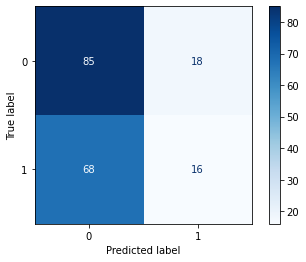

In [20]:
cm = confusion_matrix(validation_generator.classes, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [14]:
score = model.evaluate(validation_generator, verbose=1)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], score[1]*100))

12/12 [==============================] - 6s 492ms/step - loss: 2.5646 - top_k_categorical_accuracy: 0.5455 - acc: 0.4064
evaluate top_k_categorical_accuracy: 54.55%
